
# Trabalho 2 - Uso de AutoML em Machine Learning

Este notebook explora o uso de AutoML para automatizar o processo de seleção e tuning de modelos. Os tópicos incluem:

1. Introdução ao AutoML e Configuração
2. Aplicação de AutoML em um Conjunto de Dados
3. Análise e Interpretação dos Resultados obtidos


# Aprendizado de Máquina -- Exercício 2

Professor: Sérgio Nery Simões

Nome completo do aluno:


## Auto Machine Learning -- Classifier

Materiais de AutoML

https://arxiv.org/pdf/1907.08392v1.pdf

https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf


Métricas

https://en.wikipedia.org/wiki/Precision_and_recall

Pipeline

https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf

https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976

https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines


---

## Trabalho 2: AutoML (CASH) e Pipeline

Neste segundo exercício, você implementará uma função para automatizar o processo de seleção de modelo e hiperparametrização para um determinado conjunto de dados.
Basicamente, você utilizará um conjunto de dados (que será dividido em treinamento, validação e teste) para treinar, validar e avaliar diversos modelos e retornar o modelo com o melhor resultado para uma determinada métrica (Ex: Acurácia ou Medida F1).

Para o ajuste dos hiperparâmetros (tuning) de cada modelo, deverá ser criado um Grid de parâmetros e validado usando GridSearchCV para validação cruzada com K-fold (K=5). Isto será realizado para todos os classificadores mas cada um terá um conjunto de grid de parâmetros diferentes e apropriados para o respectivo caso.
Por exemplo, enquanto vários classificadores poderão ter o parâmetro de regularização C, outros parâmetros como o γ  (gamma, somente serão encontrados em classificadores como SVM usando kernel RBF, por exemplo.

Você deverá informar qual o modelo que obteve a melhor configuração para (i) Acurácia, (ii) Precision, (iii) Recall e (iv) F1. Utilize pipelines para resolver esta atividade.

=============================================

Em detalhes, você deverá construir um **pipeline** -- consulte o link abaixo para obter informações sobre como fazer um pipeline):

        https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

        https://medium.com/data-hackers/como-usar-pipelines-no-scikit-learn-1398a4cc6ae9


O pipeline parametrizado deverá realizar os seguintes passos:


1) PRÉ-PROCESSAMENTO DOS DADOS: Padronização dos dados de entrada (média 0 e desvio-padrão 1); Dica: utilize o StandarScaler
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

2) SELEÇÃO DO MODELO: Validação Cruzada usando o GridSearchCV (avaliando o grid de Parâmetros) usando diferente métricas: (i) Acurácia, (ii) Precision, (iii) Recall e (iv) F1. Dica: checar o parâmetro 'scoring'.

        GridSearchCV
        https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

        Lista de valores string do parâmetro 'scoring' que você pode utilizar:
        https://scikit-learn.org/stable/modules/model_evaluation.html


Utilize este notebook como base para iniciar o trabalho.

Bom trabalho! :)


### Importing Libraries

In [ ]:
!pip install optuna
!pip install lightgbm
!pip install catboost
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.6 MB/s eta 0:00:00


In [ ]:

# Dividir os dados em conjuntos de treino e teste
# Isso ajuda a avaliar a capacidade de generalização dos modelos.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline

from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

### Gerando os dados

In [ ]:
X, y = make_classification(n_samples=2000, n_features=20, n_informative=2,
                           n_redundant=2, weights=[0.7, 0.3], random_state=42)

In [ ]:
col_names = ['x'+str(i) for i in range(1, X.shape[1]+1)] + ['CLASS']

df_data = pd.DataFrame(np.c_[X, y], columns=col_names)

In [ ]:
df_data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,CLASS
0,0.231462,-0.641639,1.162261,-0.571047,0.062669,-1.932734,2.047652,-0.249918,-1.353783,0.567940,...,0.423080,0.309730,-0.318567,-1.204309,1.069692,0.624939,-0.749361,-1.407211,3.942331,1.0
1,0.522972,0.591132,-0.958704,0.148943,-0.772951,-1.339270,-0.336320,-1.516858,-0.934485,-0.392974,...,0.204989,-0.071514,-0.893419,2.213278,-0.449866,1.375179,1.476500,1.873576,1.820967,0.0
2,-0.131981,2.935407,-1.633437,0.957263,0.224883,1.651234,1.409745,3.038282,0.284965,-2.691420,...,1.047855,0.162444,0.117998,-0.156248,-0.476224,-0.889576,2.865920,0.927649,0.983906,0.0
3,0.631804,-1.764013,1.203177,-0.011081,-2.360726,-0.953579,1.002952,-0.708234,-0.160513,2.022730,...,-0.499515,1.312825,-0.878339,-0.569104,-0.450267,0.790533,0.723982,0.467378,-0.047347,1.0
4,1.475454,-0.572854,-1.159536,0.027177,-0.129704,-0.334773,-0.621332,-0.696117,-0.370513,0.540869,...,0.012654,-1.446757,-0.148429,-0.864172,0.585813,-0.230849,-0.464967,0.809846,-0.280024,0.0


In [ ]:
X = df_data.drop('CLASS', axis=1)
y = df_data['CLASS']

### Particionando os dados

In [ ]:

# Dividir os dados em conjuntos de treino e teste
# Isso ajuda a avaliar a capacidade de generalização dos modelos.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2000, 20), (2000,), (1500, 20), (1500,), (500, 20), (500,))

### Exploring Data

After you have loaded the dataset, you might want to know a little bit more about it. You can check feature and target names.



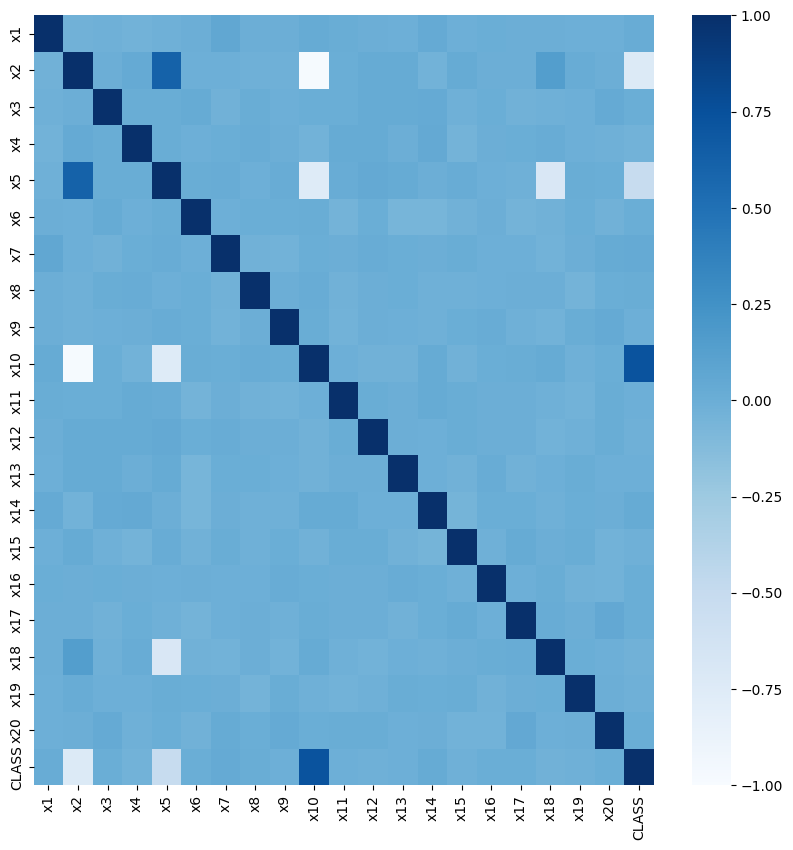

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
#sns.heatmap(df, annot=True, fmt=".3f", linewidths=.5, ax=ax);

sns.heatmap(df_data.corr(),  vmin=-1, vmax=1, cmap="Blues");

### Pipeline para tratamento dos dados numéricos e categóricos

OBS: POR ENQUANTO NÃO TEMOS AINDA AS CATEGÓRICAS,
MAS VAMOS DEIXAR O NOTEBOOK PREPARADO, OK?

In [ ]:

# Normalizar os dados para melhorar a performance dos algoritmos que dependem da escala das variáveis.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
variaveis_numericas   = X.columns
variaveis_categoricas = '' # BASTA ADICIONAR AS COLUNAS CATEGORICAS AQUI

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('Variáveis numericas', numeric_transformer, variaveis_numericas),
        #('Variáveis categoricas', categorical_transformer, variaveis_categoricas)
        ],
    remainder='drop')

### Padronizando os dados

In [ ]:
# Padronizar/ Normalizar / Escalar os dados
X_train_preprocessed = preprocessor.fit_transform(X_train)

In [ ]:
# COMANDO ABAIXO DEVE SER EXECUTADO APENAS SE QUISER DEIXAR O
# PREPROCESSING FORA DO PIPELINE.
# PODE SER UTIL PARA ECONOMIZAR TEMPO QUANDO A PADRONIZAÇÃO
# APLICADA FOR SEMPRE A MESMA
X_test_transformed   = preprocessor.transform(X_test)

---

### Preparando os parâmetros e os modelos para hiperparametrização dos classificadores

In [ ]:
# Definição dos Param Grids
params_grid_svm = [{'clf__kernel': ['rbf'],    'clf__C': [0.1, 1, 10, 100], 'clf__gamma': [0.01, 0.1, 1, 10, 100]},
                   {'clf__kernel': ['linear'], 'clf__C': [0.1, 1, 10, 100]}]

params_grid_knn = [{'clf__leaf_size': [5, 10, 20, 30], 'clf__n_neighbors': [7,9,11,13]}]

params_grid_dt  = {'clf__criterion':['gini', 'entropy'], 'clf__max_depth': [2,5,7,10,15]}

params_grid_rf  = {'clf__n_estimators': [100, 200, 500], # Number of trees in random forest
                   'clf__max_features': ['auto'], # Number of features to consider at every split
                   'clf__max_depth': [2, 5, 10], # Maximum number of levels in tree
                   #'clf__min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
                   #'clf__min_samples_leaf': [1, 2, 4], # Minimum number of samples required at each leaf node
                   }

params_grid_lr  = {'clf__C': [0.1, 1, 10, 100],
                   'clf__solver' : ['liblinear']}
                   #'clf__penalty' : ['l1', 'l2'],


# Parameters grid for XGBoost
params_grid_xgb = {
        'clf__max_depth': [3, 5, 10],
        'clf__min_child_weight': [1, 5, 10],
        'clf__gamma': [0.5, 1, 5, 10] #,
        #'clf__subsample': [0.6, 0.8, 1.0],
        #'clf__colsample_bytree': [0.6, 0.8, 1.0],
        }

In [ ]:

# Modelo de Regressão Logística
# Treinamento e avaliação do modelo de Regressão Logística no conjunto de dados escalado.
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

# Avaliação do modelo
print("Acurácia Regressão Logística:", accuracy_score(y_test, y_pred_logreg))
print("Relatório de Classificação para Regressão Logística:\n", classification_report(y_test, y_pred_logreg))
classifiers = [
    ('KNN', params_grid_knn, KNeighborsClassifier()),
    ('SVC', params_grid_svm, SVC()),
    ('DT',  params_grid_dt,  DecisionTreeClassifier()),
    ('RF',  params_grid_rf,  RandomForestClassifier()),
    ('LR',  params_grid_lr, LogisticRegression()),
    ('XGB', params_grid_xgb, XGBClassifier())
]

In [ ]:
scores = [
          'accuracy',
          'precision',
          'recall',
          'f1',
          'roc_auc'
          ]

### Hiperparametrização e Avaliação dos classificadores

In [ ]:
for clf_name, param_grid, clf in classifiers:
    print('-----------------------------------------')
    print(clf_name, '\n', param_grid, clf)
    print('-----------------------------------------')
    for score in scores:
        print('\t-----------------------------------------')
        print('\t Ajustando parâmetros para << %s >>' % score)
        print('\t-----------------------------------------')

        # Ponha seu código aqui.
        # O código deve uusar Pipeline e validação cruzada k-fold (k=5)
        # usando a função GridSearchCV, deve otmizar para varios
        # 'scoring" diferentes conforme descrito anteriormente.

        # Pipeline

        # Validacao Cruzada

        # Saídas



-----------------------------------------
KNN 
 [{'clf__leaf_size': [5, 10, 20, 30], 'clf__n_neighbors': [7, 9, 11, 13]}] KNeighborsClassifier()
-----------------------------------------
	-----------------------------------------
	 Ajustando parâmetros para << accuracy >>
	-----------------------------------------
	-----------------------------------------
	 Ajustando parâmetros para << precision >>
	-----------------------------------------
	-----------------------------------------
	 Ajustando parâmetros para << recall >>
	-----------------------------------------
	-----------------------------------------
	 Ajustando parâmetros para << f1 >>
	-----------------------------------------
	-----------------------------------------
	 Ajustando parâmetros para << roc_auc >>
	-----------------------------------------
-----------------------------------------
SVC 
 [{'clf__kernel': ['rbf'], 'clf__C': [0.1, 1, 10, 100], 'clf__gamma': [0.01, 0.1, 1, 10, 100]}, {'clf__kernel': ['linear'], 'clf_

In [ ]:
# Graficos boxplots

-----------------------------------------
SVC 
 [{'clf__kernel': ['rbf'], 'clf__C': [0.1, 1, 10, 100], 'clf__gamma': [0.01, 0.1, 1, 10, 100]}, {'clf__kernel': ['linear'], 'clf__C': [0.1, 1, 10, 100]}] SVC()
-----------------------------------------
	-----------------------------------------
	 Ajustando parâmetros para << accuracy >>
	-----------------------------------------
	-----------------------------------------
	 Ajustando parâmetros para << precision >>
	-----------------------------------------
	-----------------------------------------
	 Ajustando parâmetros para << recall >>
	-----------------------------------------
	-----------------------------------------
	 Ajustando parâmetros para << f1 >>
	-----------------------------------------
	-----------------------------------------
	 Ajustando parâmetros para << roc_auc >>
	-----------------------------------------
-----------------------------------------
RF 
 {'clf__n_estimators': [100, 200, 500], 'clf__max_features': ['auto'

<Figure size 1500x1000 with 0 Axes>

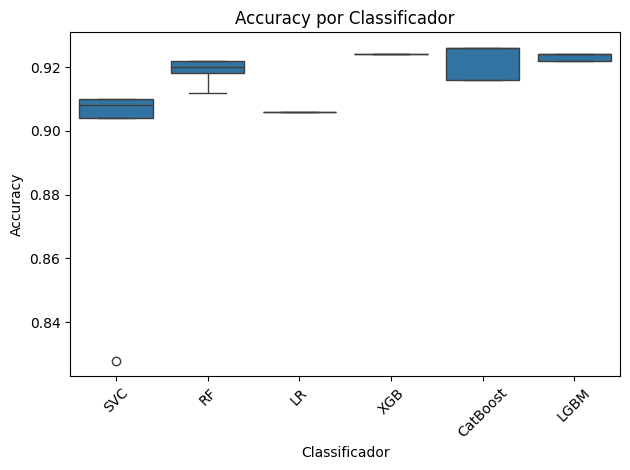

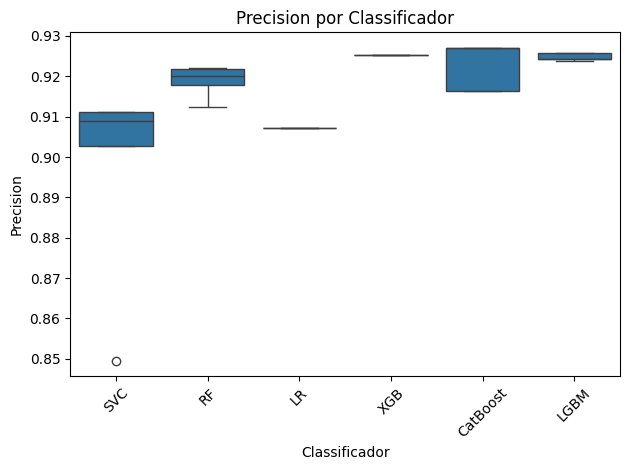

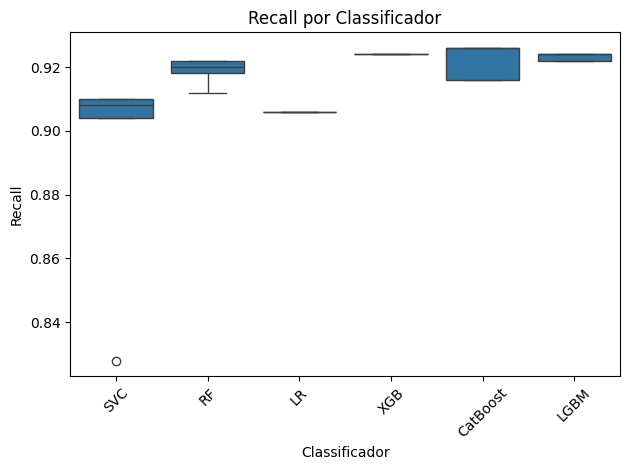

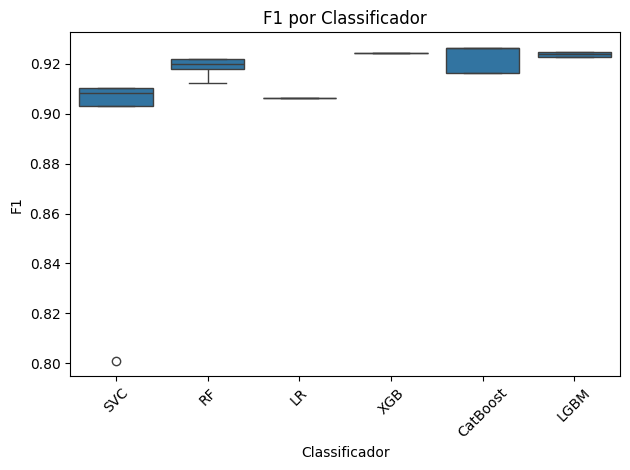

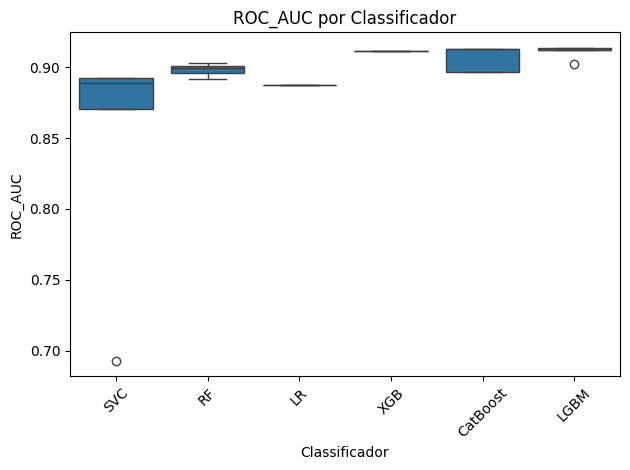

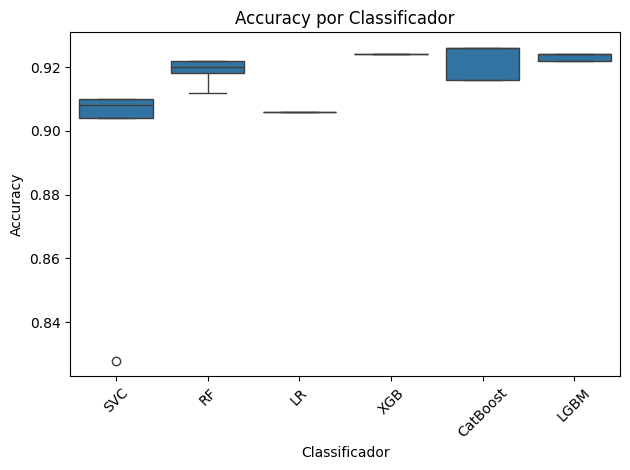

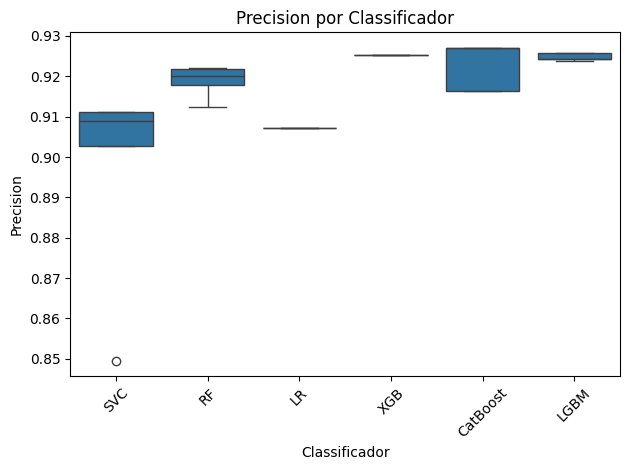

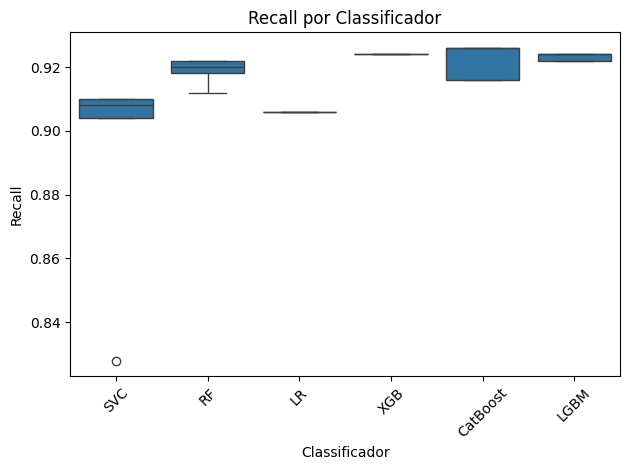

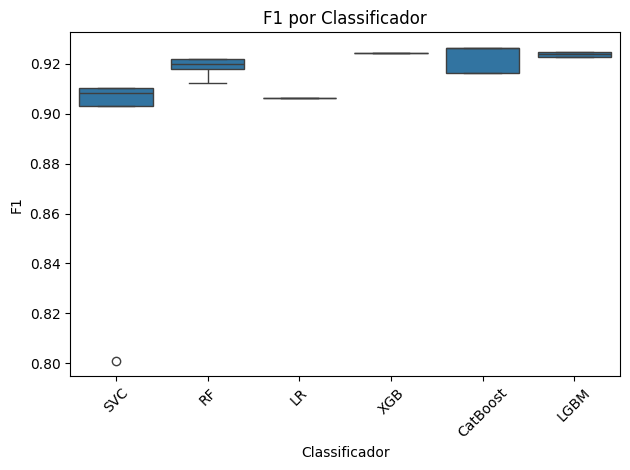

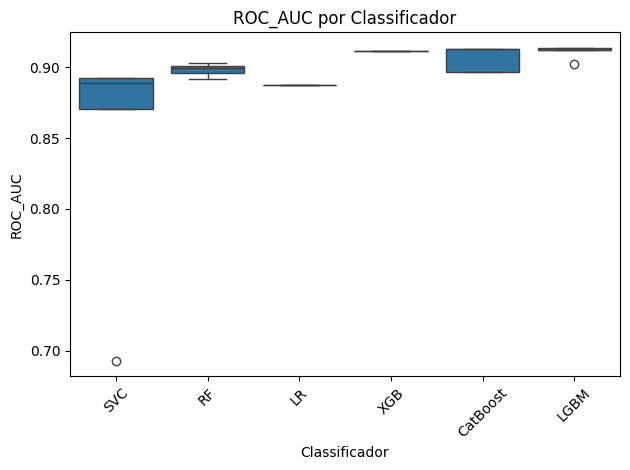

In [ ]:

# Modelo de Regressão Logística
# Treinamento e avaliação do modelo de Regressão Logística no conjunto de dados escalado.
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

# Avaliação do modelo
print("Acurácia Regressão Logística:", accuracy_score(y_test, y_pred_logreg))
print("Relatório de Classificação para Regressão Logística:\n", classification_report(y_test, y_pred_logreg))
""" CÓDIGO USANDO GRIDSEARCH, GERANDO BOXPLOT E SALVANDO OS RESULTADOS """
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

params_grid_svm = [{'clf__kernel': ['rbf'], 'clf__C': [0.1, 1, 10, 100], 'clf__gamma': [0.01, 0.1, 1, 10, 100]},
                   {'clf__kernel': ['linear'], 'clf__C': [0.1, 1, 10, 100]}]

params_grid_rf = {'clf__n_estimators': [100, 200, 500], 'clf__max_features': ['auto'], 'clf__max_depth': [2, 5, 10]}

params_grid_lr = {'clf__C': [0.1, 1, 10, 100], 'clf__solver': ['liblinear']}

params_grid_xgb = {'clf__max_depth': [3, 5, 10], 'clf__min_child_weight': [1, 5, 10], 'clf__gamma': [0.5, 1, 5, 10]}

params_grid_cat = {'clf__depth': [4, 6, 10], 'clf__learning_rate': [0.01, 0.1, 0.3], 'clf__iterations': [100, 500, 1000]}

params_grid_lgb = {'clf__num_leaves': [31, 50, 100], 'clf__learning_rate': [0.01, 0.1, 0.2], 'clf__n_estimators': [100, 200, 500]}

classifiers = [
    ('SVC', params_grid_svm, SVC()),
    ('RF', params_grid_rf, RandomForestClassifier()),
    ('LR', params_grid_lr, LogisticRegression()),
    ('XGB', params_grid_xgb, XGBClassifier()),
    ('CatBoost', params_grid_cat, CatBoostClassifier(silent=True)),
    ('LGBM', params_grid_lgb, LGBMClassifier())
]

scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

results = []

for clf_name, param_grid, clf in classifiers:
    print('-----------------------------------------')
    print(clf_name, '\n', param_grid, clf)
    print('-----------------------------------------')
    for score in scores:
        print('\t-----------------------------------------')
        print('\t Ajustando parâmetros para << %s >>' % score)
        print('\t-----------------------------------------')

        pipe = Pipeline([('clf', clf)])

        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(pipe, param_grid, cv=kfold, scoring=score, n_jobs=-1)

        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        y_pred = grid_search.predict(X_test)

        results.append({
            'Classificador': clf_name,
            'Score': score,
            'Best Score': best_score,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1': f1_score(y_test, y_pred, average='weighted'),
            'ROC_AUC': roc_auc_score(y_test, y_pred, multi_class='ovr'),
            'Params': best_params
        })

results_df = pd.DataFrame(results)

results_df.to_csv('results.csv', index=False)
results_df.to_pickle('results.pkl')

plt.figure(figsize=(15, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']

for metric in metrics:
    plt.figure()
    sns.boxplot(x='Classificador', y=metric, data=results_df)
    plt.title(f'{metric} por Classificador')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

for metric in metrics:
    plt.figure()
    sns.boxplot(x='Classificador', y=metric, data=results_df)
    plt.title(f'{metric} por Classificador')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{metric}_boxplot.png')



In [ ]:

# Dividir os dados em conjuntos de treino e teste
# Isso ajuda a avaliar a capacidade de generalização dos modelos.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
""" CÓDIGO USANDO OPTUNA, GERANDO BOXPLOT E SALVANDO OS RESULTADOS """
import warnings
warnings.filterwarnings('ignore')

import optuna
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


def objective(trial, clf_name):
    if clf_name == 'SVC':
        params = {
            'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf']),
            'C': trial.suggest_loguniform('C', 0.1, 100),
            'gamma': trial.suggest_loguniform('gamma', 0.01, 100) if trial.suggest_categorical('kernel', ['linear', 'rbf']) == 'rbf' else 'scale'
        }
        clf = SVC(**params)

    elif clf_name == 'RF':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_features': trial.suggest_categorical('max_features', ['auto']),
            'max_depth': trial.suggest_int('max_depth', 2, 10)
        }
        clf = RandomForestClassifier(**params)

    elif clf_name == 'LR':
        params = {
            'C': trial.suggest_loguniform('C', 0.1, 100),
            'solver': trial.suggest_categorical('solver', ['liblinear'])
        }
        clf = LogisticRegression(**params)

    elif clf_name == 'XGB':
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_loguniform('gamma', 0.5, 10)
        }
        clf = XGBClassifier(**params)

    elif clf_name == 'CatBoost':
        params = {
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            'iterations': trial.suggest_int('iterations', 100, 1000)
        }
        clf = CatBoostClassifier(**params, silent=True)

    elif clf_name == 'LGBM':
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 31, 100),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 500)
        }
        clf = LGBMClassifier(**params)

    pipe = Pipeline([('clf', clf)])
    score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
    return score.mean()

classifiers = ['SVC', 'RF', 'LR', 'XGB', 'CatBoost', 'LGBM']

results = []

for clf_name in classifiers:
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, clf_name), n_trials=50)
    best_params = study.best_params
    best_score = study.best_value

    if clf_name == 'SVC':
        clf = SVC(**best_params)
    elif clf_name == 'RF':
        clf = RandomForestClassifier(**best_params)
    elif clf_name == 'LR':
        clf = LogisticRegression(**best_params)
    elif clf_name == 'XGB':
        clf = XGBClassifier(**best_params)
    elif clf_name == 'CatBoost':
        clf = CatBoostClassifier(**best_params, silent=True)
    elif clf_name == 'LGBM':
        clf = LGBMClassifier(**best_params)

    pipe = Pipeline([('clf', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    results.append({
        'Classificador': clf_name,
        'Best Score': best_score,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1': f1_score(y_test, y_pred, average='weighted'),
        'ROC_AUC': roc_auc_score(y_test, y_pred, multi_class='ovr'),
        'Params': best_params
    })

results_df = pd.DataFrame(results)

results_df.to_csv('results.csv', index=False)
results_df.to_pickle('results.pkl')

plt.figure(figsize=(15, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']

for metric in metrics:
    plt.figure()
    sns.boxplot(x='Classificador', y=metric, data=results_df)
    plt.title(f'{metric} por Classificador')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

for metric in metrics:
    plt.figure()
    sns.boxplot(x='Classificador', y=metric, data=results_df)
    plt.title(f'{metric} por Classificador')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{metric}_boxplot.png')



Output hidden; open in https://colab.research.google.com to view.